# Data analysis with XGBoost (Company motorbikes registrations v Bohemia example)

This notebook demontrates how to:
1. load data from Extera Feature Store
2. feature engineering for xgboost model
3. find optimal hyperparameters for model using cross validation
4. train model
5. explain model feature importance with eli5 and shap

Corresponding article: [https://www.mindforce.ai/post/jak%C3%A9-firmy-si-v-%C4%8Dr-kupuj%C3%AD-motorky-a-jak-je-naj%C3%ADt-s-pomoci-ai](https://www.mindforce.ai/post/jak%C3%A9-firmy-si-v-%C4%8Dr-kupuj%C3%AD-motorky-a-jak-je-naj%C3%ADt-s-pomoci-ai)

## Set Up

1. Install pandas, sklearn and xgboost

In [68]:
# data load & preparation
import pandas as pd
from sklearn.model_selection import train_test_split
# data model
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
# model explain
import shap
import eli5
from eli5.sklearn import PermutationImportance
# from pandas_profiling import ProfileReport

## Load data from Extera Feature Store


In [72]:
moto_data_query = '''
--26k records for 11k entrepreneurs, 16k companies 
with vozidla_L as
  (
  SELECT 
  fsob.* except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky),
  if(vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky>0,1,0) as moto_class_target
  FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
  inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
  where fsob.sid in
    (
    select distinct owner_sid from `steady-vine-203410.nexus.vehicle_registration` vr 
    where vr.vehicle_category_code in ('L') --  motorbikes
    )
  and org.abolishment_date = '9999-12-31' -- companies/entrepreneurs still alive
  )
/*11 *5 = 55k sample entrepreneurs*/
, non_L_sample_ent as
  (
  select
  fsob.* except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky),
  0 as moto_class_target
  FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
  inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
  where fsob.sid not in (select sid from vozidla_L) 
  -- minimum record quality requirements
  and org.region is not null 
  and org.nace_level_2 is not null
  and org.abolishment_date = '9999-12-31'
  and org.interruption_date is null
  and org.ent_flag = 'Y'
  order by sid desc # = by hash = random
  limit 55000
)
, non_L_sample_comp as
  (
  select
  fsob.* except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky),
  0 as moto_class_target
  FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
  inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
  where fsob.sid not in (select sid from vozidla_L) 
  -- minimum record quality requirements
  and org.region is not null 
  and org.nace_level_2 is not null
  and org.abolishment_date = '9999-12-31'
  and org.turnover_category_code is not null
  and org.ent_flag = 'N'
  order by sid desc # = by hash = random
  limit 80000
)
select * except (sid) from vozidla_L
union all
select * except (sid) from non_L_sample_ent
union all
select * except (sid) from non_L_sample_comp
'''

moto_model_data = pd.read_gbq(project_id='steady-vine-203410',query = moto_data_query)

## Data preparation & feature engineering for xgboost model


In [73]:
x, y = moto_model_data.iloc[:,:-1],moto_model_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)

### XGB model fit + eval

## Find best model hyperparameters

In [85]:
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model,{'max_depth': [6],'learning_rate':[0.1],'scale_pos_weight':[0.5,1,2]}, verbose=1,n_jobs=4,cv=3,scoring = 'precision')
clf.fit(x,y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:03:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.759950280466431
{'learning_rate': 0.1, 'max_depth': 6, 'scale_pos_weight': 0.5}


## Train model

In [91]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)
# moto_model = xgb.XGBClassifier(use_label_encoder =False, scale_pos_weight=4, learning_rate=0.2,max_depth=9) #good recall
# moto_model = xgb.XGBClassifier(use_label_encoder =False, scale_pos_weight=0.2, learning_rate=0.1,max_depth=6) #good precision
moto_model = xgb.XGBClassifier(use_label_encoder =False, scale_pos_weight=0.4, learning_rate=0.1,max_depth=7) #good precision
moto_model.fit(X_train,y_train)
Y_pred = moto_model.predict(X_test)
print(classification_report(y_test,Y_pred)) 

[23:10:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     27052
           1       0.89      0.51      0.65      5240

    accuracy                           0.91     32292
   macro avg       0.90      0.75      0.80     32292
weighted avg       0.91      0.91      0.90     32292



Parameter optimization
Fitting 3 folds for each of 225 candidates, totalling 675 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 34.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 80.7min
[Parallel(n_jobs=4)]: Done 675 out of 675 | elapsed: 123.8min finished
0.40154768488724507
{'learning_rate': 0.25, 'max_depth': 5, 'scale_pos_weight': 5}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

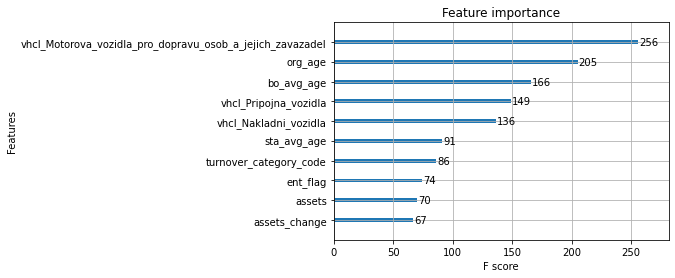

In [90]:
xgb.plot_importance(moto_model, max_num_features=10, importance_type='weight')